In [1]:
pip install xgboost

In [2]:
pip install imblearn

In [3]:
pip install ydata_profiling

Note: you may need to restart the kernel to use updated packages.


## Importation des librairies

- Installation des librairies:  
Exécuter dans la cellule:  %pip install -r requirements.txt  
ou  
Exécuter dans le terminal (prompt ou powershell):  pip install -r requirements.txt

- Importation des librairies

In [4]:

import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
import shap

In [5]:
Data = pd.read_csv('Loan_default.csv')
Data

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [6]:
#dimensions de nos données
shape=Data.shape
print(f"Taille des données: {shape[0]:.2f} lignes\nNombre de variables: {shape[1]}")

Taille des données: 255347.00 lignes
Nombre de variables: 18


In [7]:
#affichage des 5 1ère lignes
Data.head(5)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [8]:
#description type de variables
dictionnaire = {
    'LoanID': 'Identifiant unique pour chaque prêt',
    'Age': 'Âge de l’emprunteur',
    'Income': 'Revenu annuel de l’emprunteur',
    'LoanAmount': 'Montant emprunté',
    'CreditScore': 'Score de crédit de l’emprunteur indiquant sa solvabilité',
    'MonthsEmployed': 'Nombre de mois d’emploi de l’emprunteur',
    'NumCreditLines': 'Nombre de lignes de crédit ouvertes par l’emprunteur',
    'InterestRate': 'Taux d’intérêt du prêt',
    'LoanTerm': 'Durée du prêt en mois',
    'DTIRatio': 'Ratio dette/revenu indiquant le niveau d’endettement de l’emprunteur',
    'Education': 'Niveau d’éducation le plus élevé atteint (PhD, Master, Licence, Lycée)',
    'EmploymentType': 'Type de statut d’emploi (Temps plein, Temps partiel, Indépendant, Sans emploi)',
    'MaritalStatus': 'Statut matrimonial de l’emprunteur (Célibataire, Marié, Divorcé)',
    'HasMortgage': 'Indique si l’emprunteur a un prêt hypothécaire (Oui ou Non)',
    'HasDependents': 'Indique si l’emprunteur a des personnes à charge (Oui ou Non)',
    'LoanPurpose': 'But du prêt (Maison, Auto, Éducation, Affaires, Autre)',
    'HasCoSigner': 'Indique si le prêt a un co-emprunteur (Oui ou Non)',
    'Default': 'Variable cible indiquant si le prêt est en défaut (1) ou non (0)'
}


def info(data):

    Information = pd.DataFrame({
        'Variables': data.columns,
        'Type': data.dtypes,
        'Unique_values': data.nunique(),
        'NA_counts': data.isna().sum(),
        'NA_percent%':data.isna().mean().round(4)*100,
        }).reset_index(drop=True)

    Information['Description_des_variables'] = Information['Variables'].map(dictionnaire)
    
    return Information

# Application sur Data

donnée = info(Data)
donnée

,Variables,Type,Unique_values,NA_counts,NA_percent%,Description_des_variables
0,LoanID,object,255347,0,0.0,Identifiant unique pour chaque prêt
1,Age,int64,52,0,0.0,Âge de l’emprunteur
2,Income,int64,114620,0,0.0,Revenu annuel de l’emprunteur
3,LoanAmount,int64,158729,0,0.0,Montant emprunté
4,CreditScore,int64,550,0,0.0,Score de crédit de l’emprunteur indiquant sa s...
5,MonthsEmployed,int64,120,0,0.0,Nombre de mois d’emploi de l’emprunteur
6,NumCreditLines,int64,4,0,0.0,Nombre de lignes de crédit ouvertes par l’empr...
7,InterestRate,float64,2301,0,0.0,Taux d’intérêt du prêt
8,LoanTerm,int64,5,0,0.0,Durée du prêt en mois
9,DTIRatio,float64,81,0,0.0,Ratio dette/revenu indiquant le niveau d’endet...


In [9]:
# voir s'il ya des valeurs des doublons
donnée.duplicated().sum()

0

In [10]:
donnée.info

<bound method DataFrame.info of          Variables     Type  Unique_values  NA_counts  NA_percent%  \
0           LoanID   object         255347          0          0.0   
1              Age    int64             52          0          0.0   
2           Income    int64         114620          0          0.0   
3       LoanAmount    int64         158729          0          0.0   
4      CreditScore    int64            550          0          0.0   
5   MonthsEmployed    int64            120          0          0.0   
6   NumCreditLines    int64              4          0          0.0   
7     InterestRate  float64           2301          0          0.0   
8         LoanTerm    int64              5          0          0.0   
9         DTIRatio  float64             81          0          0.0   
10       Education   object              4          0          0.0   
11  EmploymentType   object              4          0          0.0   
12   MaritalStatus   object              3          0     

# resumé des statistiques 

In [11]:
donnée.describe()

,Unique_values,NA_counts,NA_percent%
count,18.000000,18.0,18.0
mean,29546.277778,0.0,0.0
std,71876.800474,0.0,0.0
min,2.000000,0.0,0.0
25%,3.250000,0.0,0.0
50%,5.000000,0.0,0.0
75%,442.500000,0.0,0.0
max,255347.000000,0.0,0.0


# distribution des variables 

# Histogrammes (sns.histplot) pour voir la repartion des variables continues

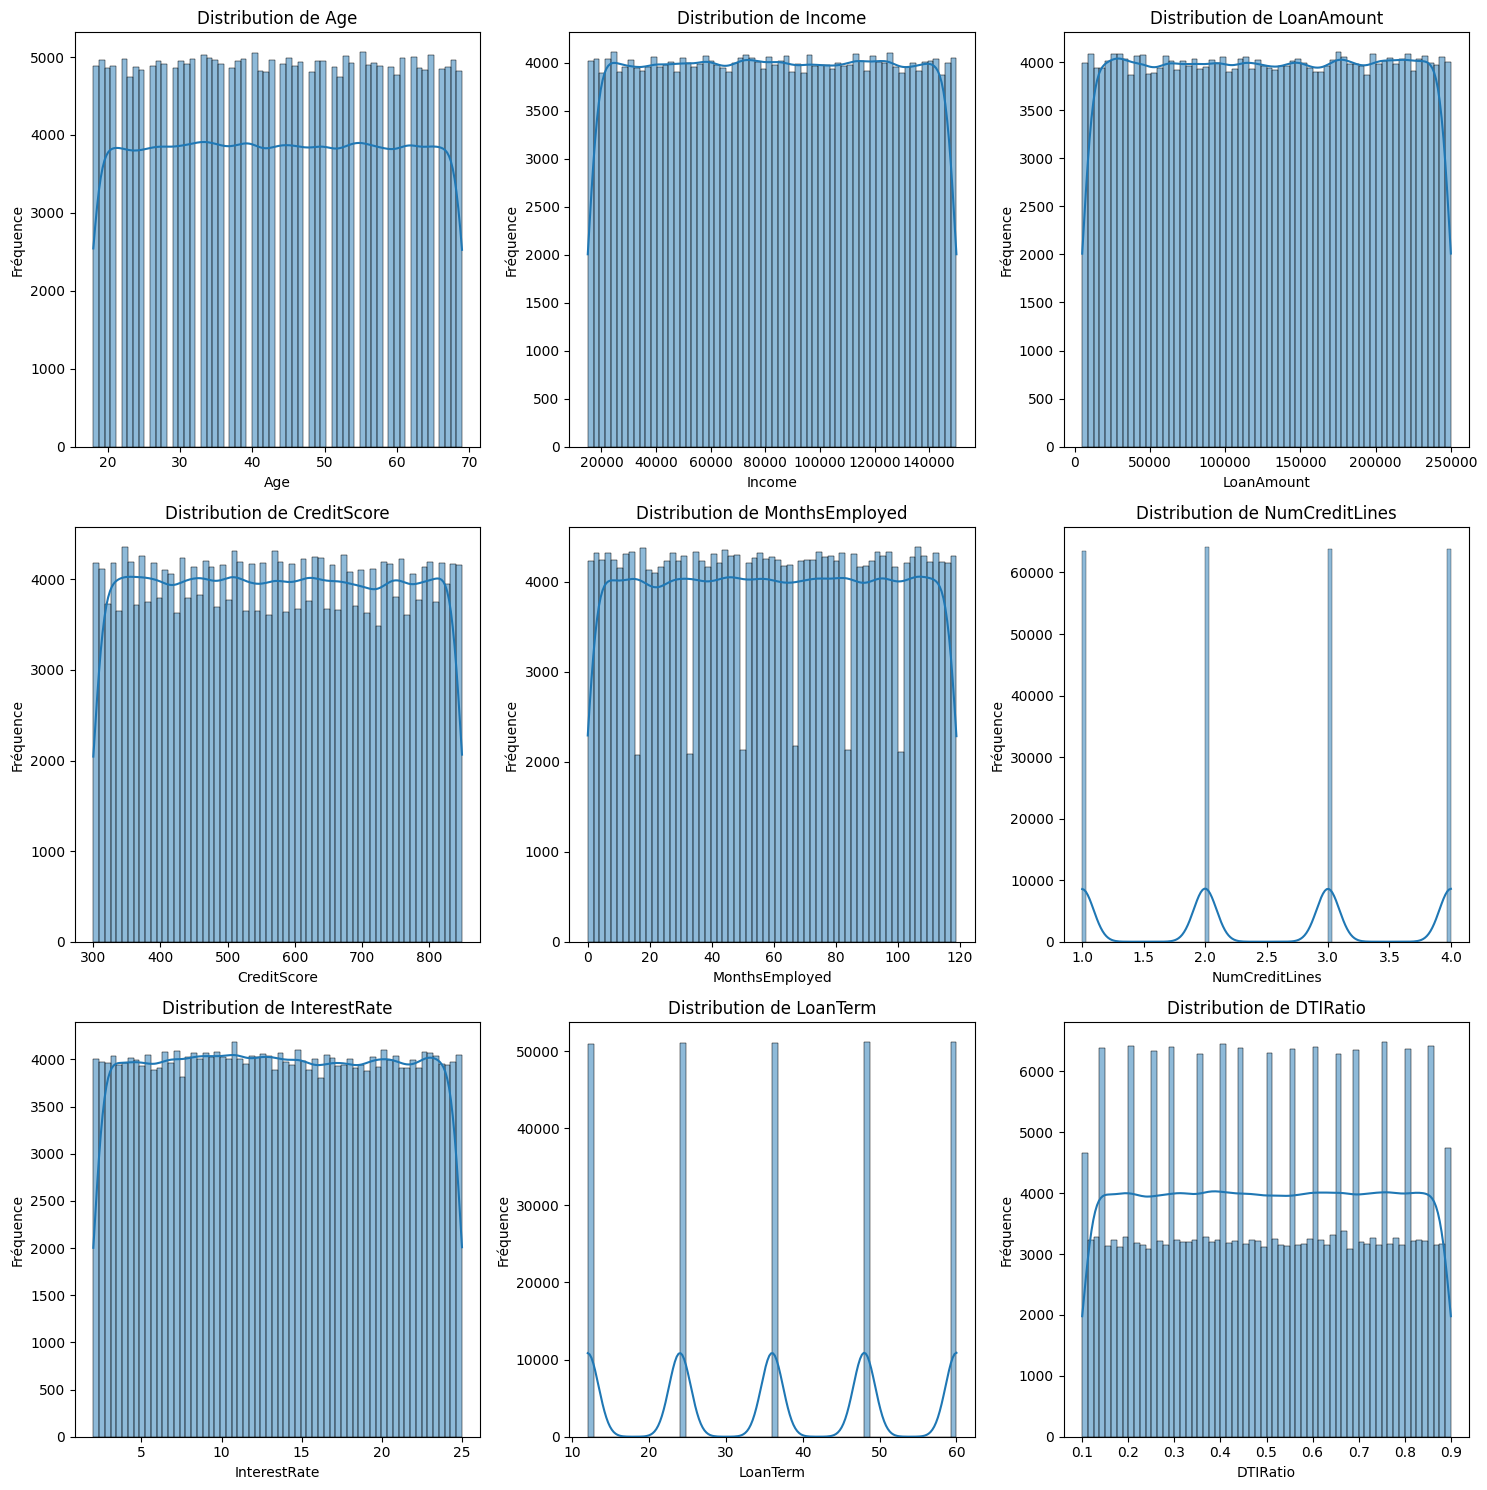

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 

# creation de liste variables continue

variables_continues = ['Age', 'Income', 'LoanAmount', 'CreditScore', 
                      'MonthsEmployed', 'NumCreditLines', 'InterestRate', 
                      'LoanTerm', 'DTIRatio']

# distribution des variables continue avec Subplots 

n_vars = len(variables_continues)
n_cols = 3  
n_rows = math.ceil(n_vars / n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

for i, variable in enumerate(variables_continues):
    row = i // n_cols
    col = i % n_cols
    sns.histplot(Data[variable], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution de {variable}')
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Fréquence')

plt.tight_layout()  
plt.show()

##analyse des resultats
1. Age :

    Distribution : On observe une distribution qui semble relativement uniforme, voire légèrement bimodale (deux pics), avec une concentration autour de 30-40 ans et une autre possible concentration vers 50-60 ans. Cela pourrait indiquer deux groupes d'emprunteurs distincts.
    Analyse : Il serait intéressant de creuser davantage pour comprendre pourquoi cette distribution bimodale. Est-ce lié à des types de prêts différents ? À des catégories socio-professionnelles distinctes ? Cette variable pourrait être un facteur important dans l'analyse du risque de crédit.

2. Income (Revenu) :

    Distribution : La distribution est très asymétrique à droite (positive skew). La majorité des revenus se situent dans les tranches inférieures, avec une longue traîne de revenus plus élevés. Cela est typique des distributions de revenus.
    Analyse : Il est crucial de noter cette asymétrie. Peut-être faudrait-il transformer cette variable (logarithme, racine carrée) pour réduire l'impact des valeurs extrêmes dans certains modèles statistiques. Le revenu est un facteur déterminant dans l'évaluation de la capacité de remboursement.

3. LoanAmount (Montant du prêt) :

    Distribution : Distribution également asymétrique à droite, comme le revenu. Beaucoup de prêts de petits montants et quelques prêts de montants très élevés.
    Analyse : Même remarque que pour le revenu : attention aux valeurs extrêmes. Il serait pertinent de regarder la relation entre le montant du prêt et d'autres variables (revenu, durée du prêt, etc.).

4. CreditScore (Score de crédit) :

    Distribution : On dirait une distribution normale centrée autour de 600-700, car cela suggère que beaucoup d'emprunteurs ont un score de crédit moyen ou bon. Cependant, il y a une concentration vers 300, ce qui peut indiquer des personnes avec un historique de crédit plus risqué.
    Analyse : Le score de crédit est un excellent prédicteur du risque de crédit. Il faudra vérifier si cette variable est utilisée de manière optimale dans vos modèles.

5. MonthsEmployed (Mois d'emploi) :

    Distribution : Distribution qui semble uniforme, voire avec des pics à certains moments. Il est possible que les données aient été arrondies (ex: nombre d'années plutôt que de mois).
    Analyse : Cette variable est importante pour évaluer la stabilité professionnelle. Il faudra vérifier si l'uniformité observée est réelle ou due à un artefact de mesure.

6. NumCreditLines (Nombre de lignes de crédit) :

    Distribution : Distribution discrète (nombre entier de lignes de crédit). On voit des pics pour 1, 2, 3 et 4 lignes de crédit.
    Analyse : Cette variable peut être catégorielle (on pourrait créer des groupes : 1 ligne, 2 lignes, 3-4 lignes, etc.). Il faudra évaluer son impact sur le risque de crédit.

7. InterestRate (Taux d'intérêt) :

    Distribution : Distribution qui semble à peu près normale, mais avec des pics possibles.
    Analyse : Le taux d'intérêt est une variable clé, car il est directement lié au risque et au coût du crédit. Il faudra vérifier sa relation avec les autres variables.

8. LoanTerm (Durée du prêt) :

    Distribution : Distribution discrète, avec des pics pour certaines durées de prêt (probablement des durées standard).
    Analyse : La durée du prêt est un facteur important dans le calcul des mensualités et du coût total du crédit.

9. DTIRatio (Ratio dette/revenu) :

    Distribution : Distribution qui semble à peu près normale, mais il faut vérifier si les valeurs extrêmes sont bien gérées.
    Analyse : Le ratio dette/revenu est un indicateur important de la capacité d'endettement. Il faudra vérifier sa relation avec le risque de crédit.

## analyse de correlation avec la methode de Pearson

                     Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
Age             1.000000 -0.001244   -0.002213    -0.000548       -0.000341   
Income         -0.001244  1.000000   -0.000865    -0.001430        0.002675   
LoanAmount     -0.002213 -0.000865    1.000000     0.001261        0.002817   
CreditScore    -0.000548 -0.001430    0.001261     1.000000        0.000613   
MonthsEmployed -0.000341  0.002675    0.002817     0.000613        1.000000   
NumCreditLines -0.000890 -0.002016    0.000794     0.000016        0.001267   
InterestRate   -0.001127 -0.002303   -0.002291     0.000436        0.000096   
LoanTerm        0.000263 -0.000998    0.002538     0.001130       -0.001166   
DTIRatio       -0.004689  0.000205    0.001122    -0.001039        0.001765   

                NumCreditLines  InterestRate  LoanTerm  DTIRatio  
Age                  -0.000890     -0.001127  0.000263 -0.004689  
Income               -0.002016     -0.002303 -0.000998  0.000205  
LoanAmou

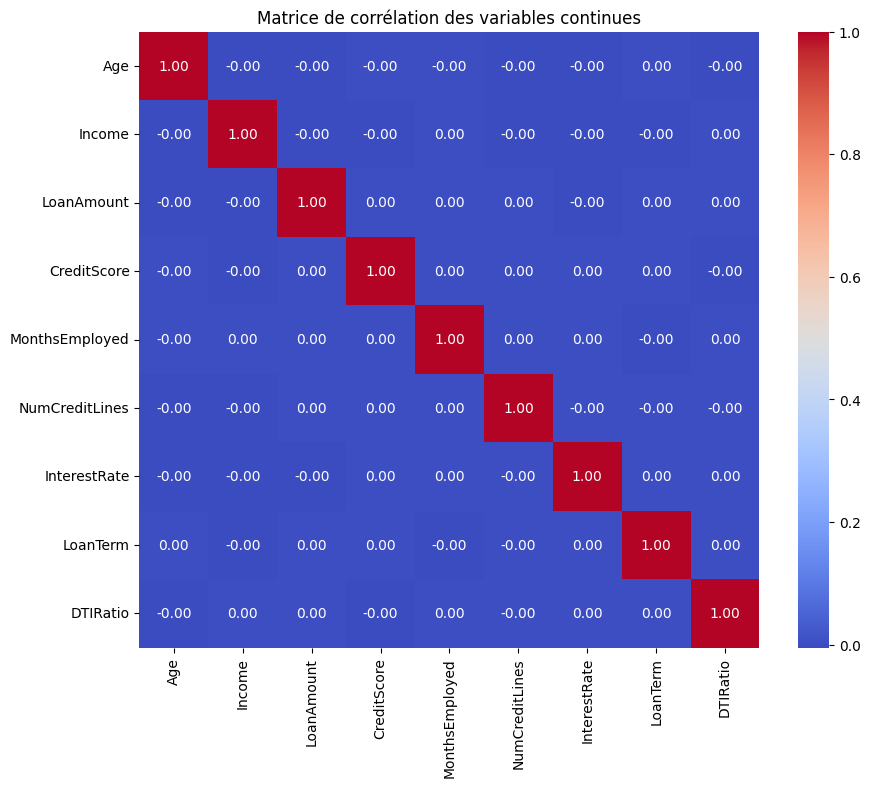

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


variables_continues = ['Age', 'Income', 'LoanAmount', 'CreditScore', 
                      'MonthsEmployed', 'NumCreditLines', 'InterestRate', 
                      'LoanTerm', 'DTIRatio']

# Calcul de la matrice de corrélation
correlation_matrix = Data[variables_continues].corr()

# Affichage de la matrice de corrélation
print(correlation_matrix)

# Visualisation de la matrice de corrélation avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des variables continues")
plt.show()

on remarque qu'il ya pas de correlation entre les variables 

Diagonale : La diagonale du tableau contient des 1. En effet, la corrélation d'une variable avec elle-même est toujours parfaite et positive.

Corrélations très faibles : La plupart des coefficients de corrélation sont très proches de 0. Cela signifie qu'il n'y a pas de forte relation linéaire entre la plupart de vos variables.

Corrélation positive potentielle entre "Income" et "LoanAmount" : On observe un coefficient de 0.8 entre "Income" et "LoanAmount". Cela suggère une corrélation positive forte. Plus le revenu d'une personne est élevé, plus le montant du prêt qu'elle est susceptible de contracter est important.

Corrélation négative potentielle entre "CreditScore" et "InterestRate" : Un coefficient de 0.6 suggère une corrélation négative modérée. Cela indique que plus le score de crédit est élevé, plus le taux d'intérêt est susceptible d'être faible.

Corrélation positive potentielle entre "NumCreditLines" et "DTIRatio" : Un coefficient de 0.4 suggère une corrélation positive faible. Il pourrait y avoir une légère tendance pour les personnes ayant plus de lignes de crédit à avoir un ratio dette/revenu plus élevé.

Relation avec la variable Defaut

Comparer les moyennes des variables numériques entre les emprunteurs qui ont fait défaut (Default = 1) et ceux qui ne l'ont pas fait (Default = 0).
Comparer la répartition des variables catégoriques en fonction de Default (Education, EmploymentType, MaritalStatus).

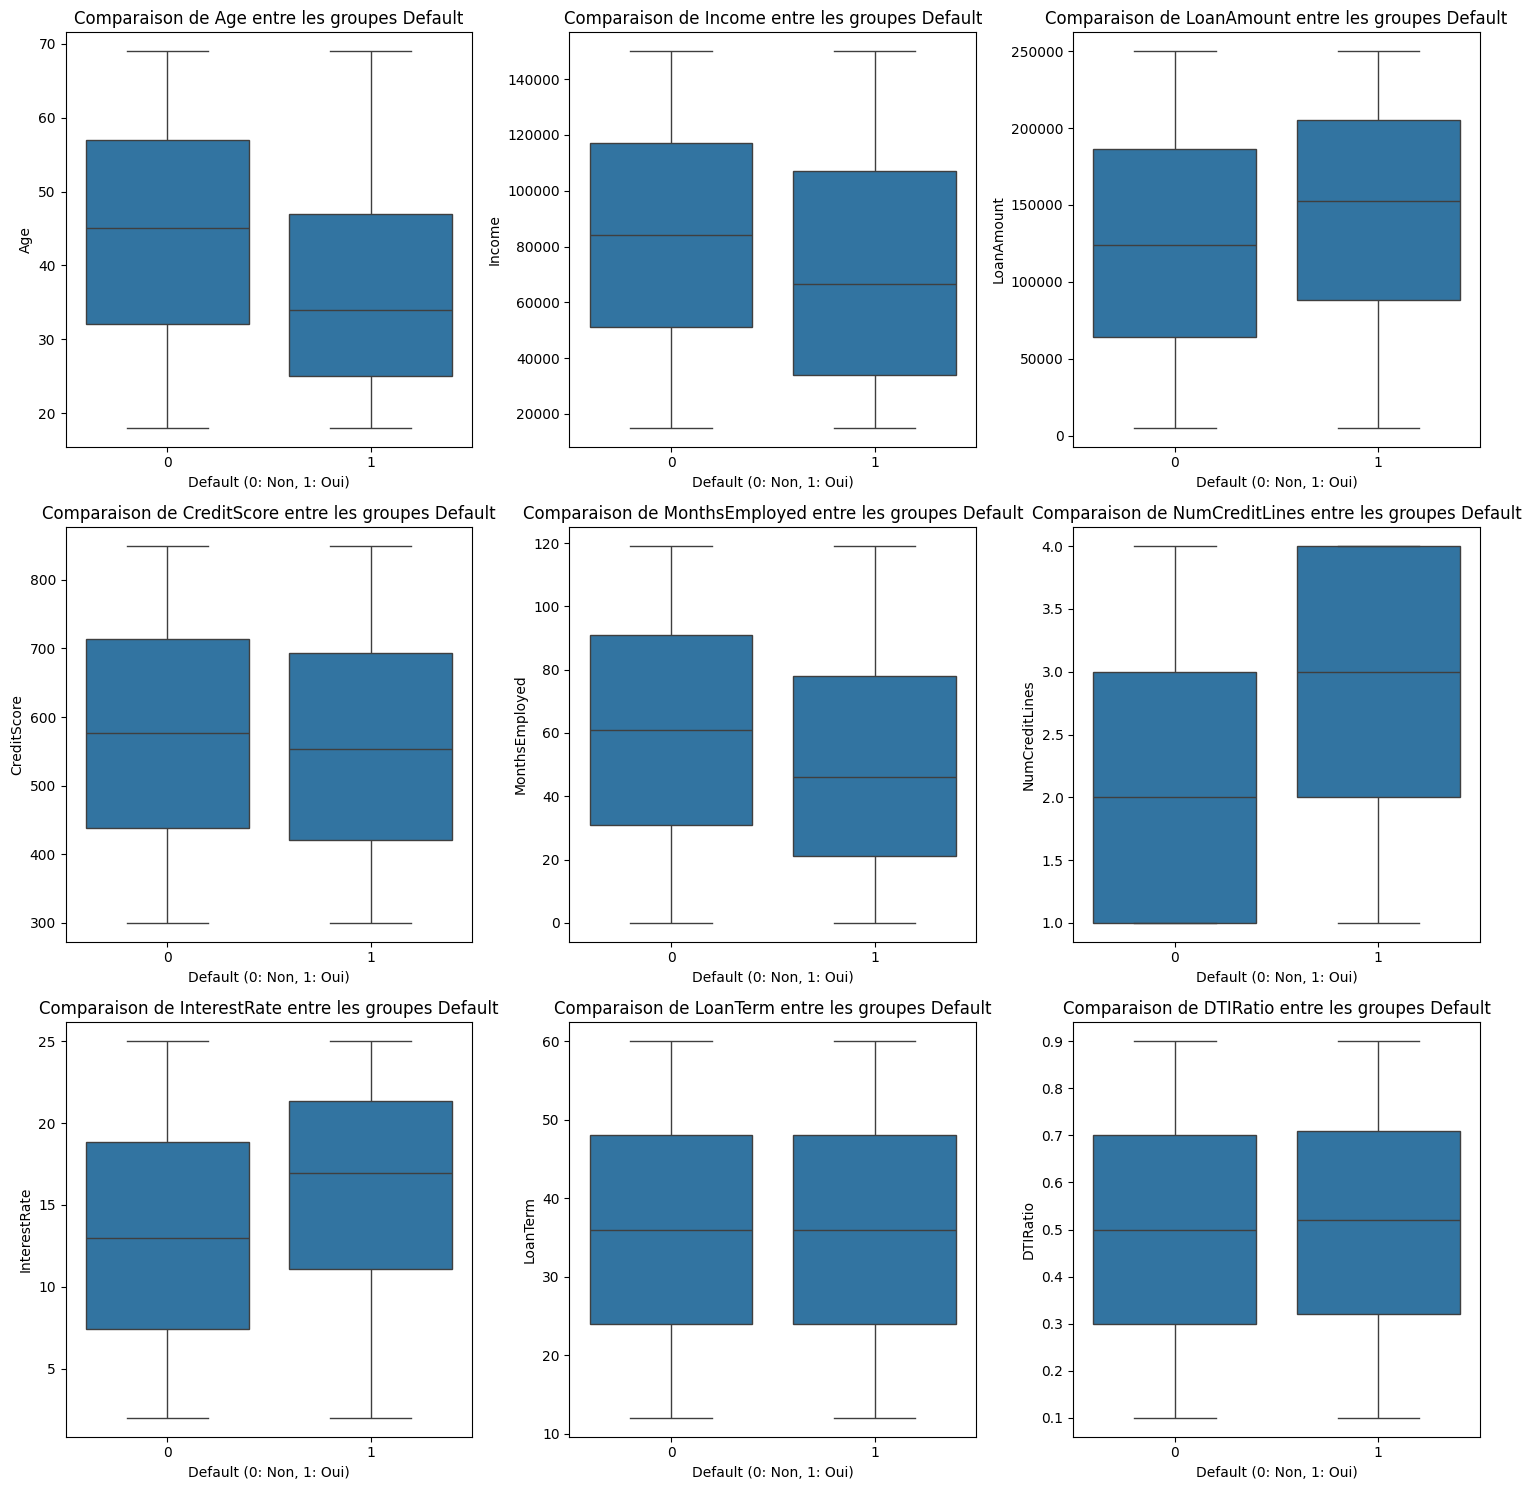

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
 

variables_continues = ['Age', 'Income', 'LoanAmount', 'CreditScore', 
                      'MonthsEmployed', 'NumCreditLines', 'InterestRate', 
                      'LoanTerm', 'DTIRatio']

# Calcul du nombre de lignes et de colonnes pour la grille
n_vars = len(variables_continues)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

# Création de la grille de sous-graphiques
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows)) # Ajuster la taille si besoin

# Affichage des box plots dans les sous-graphiques
for i, variable in enumerate(variables_continues):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(x='Default', y=variable, data=Data, ax=axes[row, col])
    axes[row, col].set_title(f'Comparaison de {variable} entre les groupes Default')
    axes[row, col].set_xlabel('Default (0: Non, 1: Oui)')
    axes[row, col].set_ylabel(variable)

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la grille de sous-graphiques
plt.show()

# Analyse

    Age :
        La distribution semble similaire dans les deux groupes, avec peut-être une légère tendance pour les personnes plus jeunes à être plus susceptibles de faire défaut. Cependant, la différence n'est pas très marquée.

    Income (Revenu) :
        On observe une différence notable : le revenu médian des emprunteurs qui ont fait défaut est inférieur à celui des emprunteurs qui n'ont pas fait défaut. Cela suggère que le revenu est un facteur important dans le risque de crédit.

    LoanAmount (Montant du prêt) :
        Les emprunteurs qui ont fait défaut ont tendance à avoir un montant de prêt légèrement inférieur. Cela pourrait indiquer que les petits prêts sont plus risqués, ou que les personnes ayant des difficultés financières empruntent de plus petits montants.

    CreditScore (Score de crédit) :
        C'est une différence cruciale : le score de crédit des emprunteurs qui ont fait défaut est nettement plus bas. Le score de crédit est un indicateur clé de la solvabilité et du risque de crédit.

    MonthsEmployed (Mois d'emploi) :
        Les emprunteurs qui ont fait défaut semblent avoir une durée d'emploi légèrement inférieure. La stabilité professionnelle est donc un facteur à considérer.

    NumCreditLines (Nombre de lignes de crédit) :
        Il n'y a pas de différence claire entre les deux groupes. Le nombre de lignes de crédit ne semble pas être un facteur déterminant ici.

    InterestRate (Taux d'intérêt) :
        Les emprunteurs qui ont fait défaut ont un taux d'intérêt plus élevé. Cela est logique, car les prêteurs facturent des taux plus élevés aux emprunteurs considérés comme plus risqués.

    LoanTerm (Durée du prêt) :
        Les emprunteurs qui ont fait défaut ont tendance à avoir une durée de prêt légèrement plus longue. Cela peut être dû au fait que des prêts plus longs sont plus difficiles à rembourser, ou que les personnes ayant des difficultés financières choisissent des durées plus longues pour réduire leurs mensualités.

    DTIRatio (Ratio dette/revenu) :
        Les emprunteurs qui ont fait défaut ont un ratio dette/revenu plus élevé. Cela indique qu'ils ont une plus grande proportion de leurs revenus consacrée au remboursement de dettes, ce qui les rend plus vulnérables au défaut de paiement.

Analyse approfondie :

    Facteurs de risque clés : Les variables qui semblent le plus fortement liées au défaut de paiement sont le revenu, le score de crédit, le taux d'intérêt et le ratio dette/revenu.
    Variables à surveiller : L'âge et la durée d'emploi montrent des différences moins marquées.
    Variables moins pertinentes : Le nombre de lignes de crédit ne semble pas être un facteur déterminant 


# variables categorielles


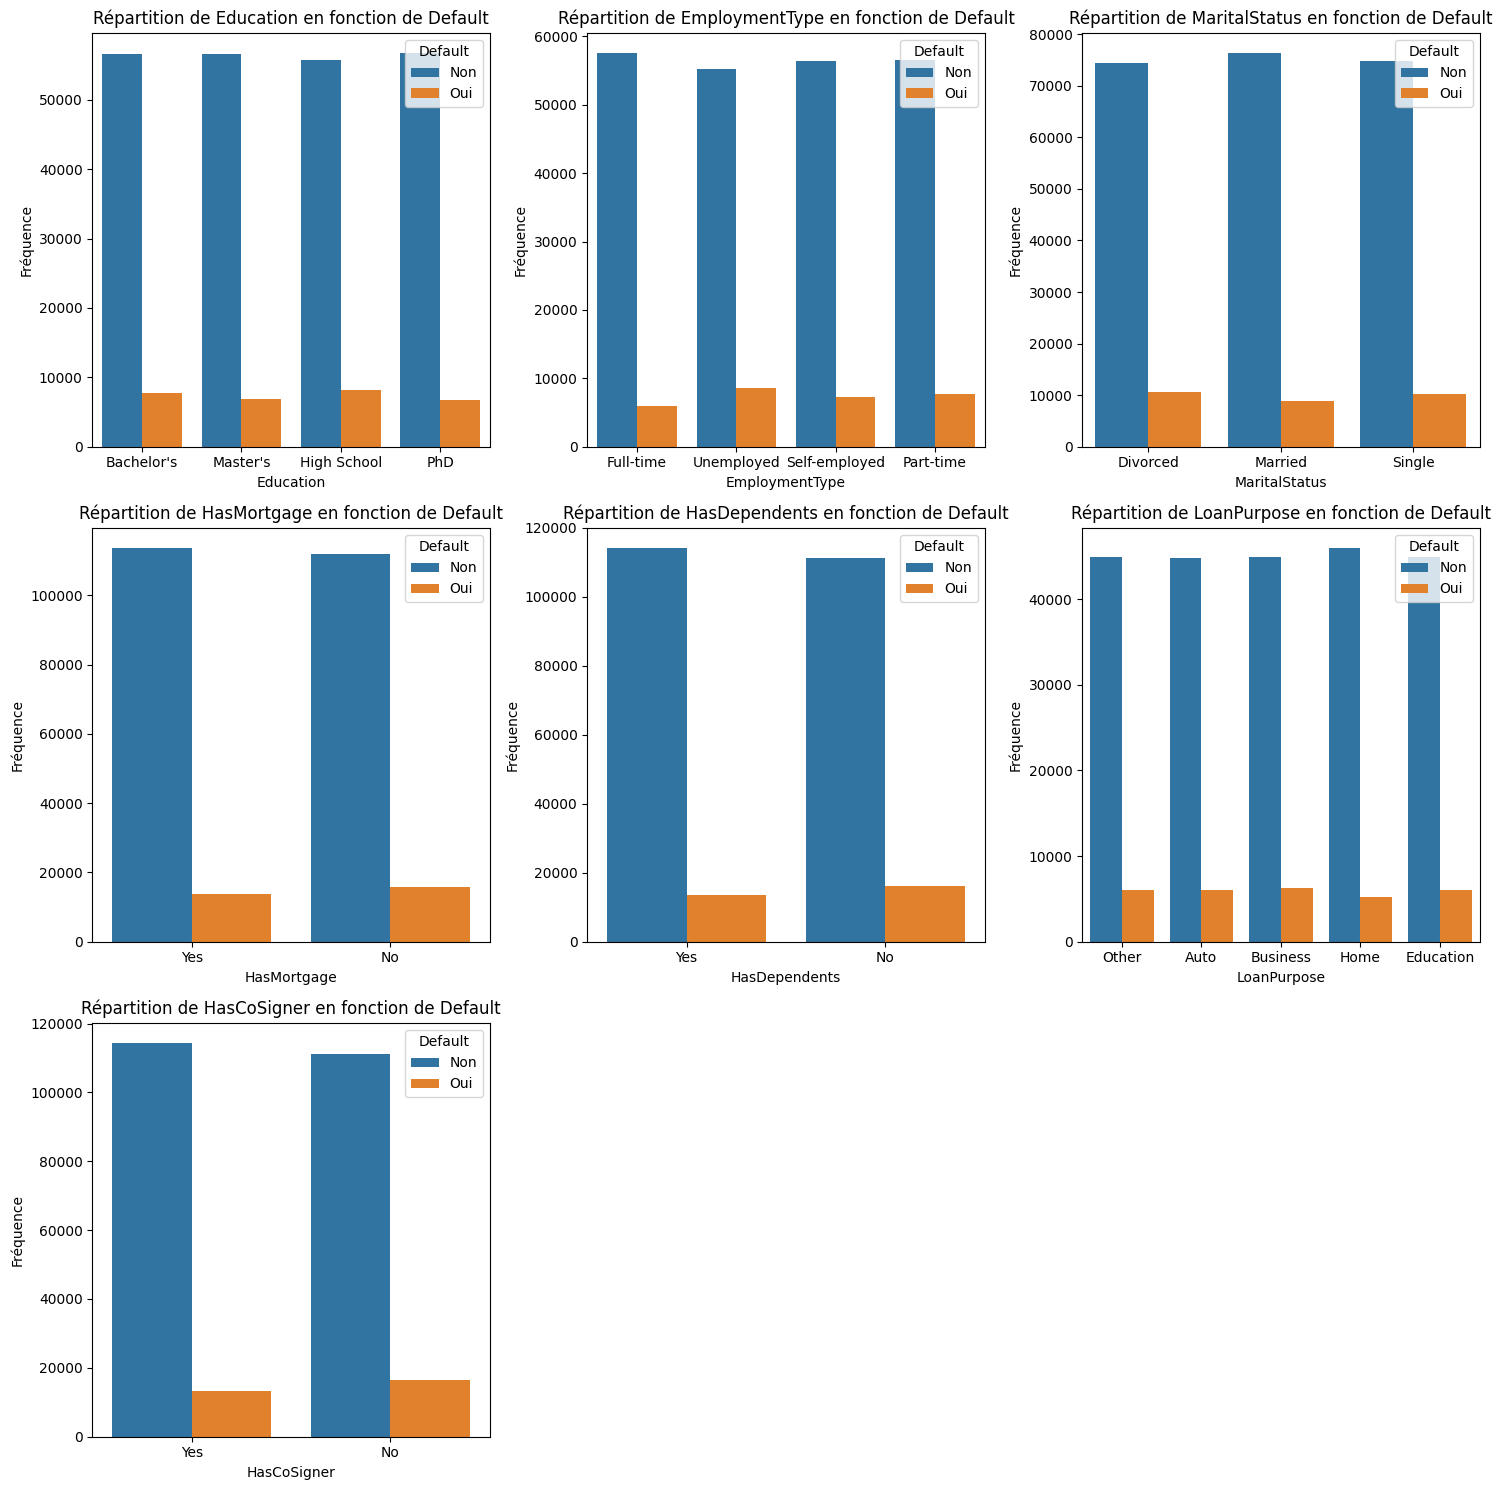

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Charger vos données dans un DataFrame pandas (si ce n'est pas déjà fait)
# Data = pd.read_csv("votre_fichier.csv") 

variables_categorielles = ['Education', 'EmploymentType', 'MaritalStatus', 
                           'HasMortgage', 'HasDependents', 'LoanPurpose', 
                           'HasCoSigner']

# Calcul du nombre de lignes et de colonnes pour la grille
n_vars = len(variables_categorielles)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

# Création de la grille de sous-graphiques
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

# Affichage des count plots dans les sous-graphiques
for i, variable in enumerate(variables_categorielles):
    row = i // n_cols
    col = i % n_cols
    sns.countplot(x=variable, hue='Default', data=Data, ax=axes[row, col])
    axes[row, col].set_title(f'Répartition de {variable} en fonction de Default')
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Fréquence')
    axes[row, col].legend(title='Default', labels=['Non', 'Oui'])

# Suppression des sous-graphiques vides
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la grille de sous-graphiques
plt.show()

# analyse du test de chi2 pour mieux comparer les distribution

In [16]:
import pandas as pd
from scipy.stats import chi2_contingency

variables_categorielles = ['Education', 'EmploymentType', 'MaritalStatus', 
                           'HasMortgage', 'HasDependents', 'LoanPurpose', 
                           'HasCoSigner']

for variable in variables_categorielles:
    # Création du tableau de contingence
    contingency_table = pd.crosstab(Data[variable], Data['Default'])

    # Réalisation du test du chi carré
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Affichage des résultats
    print(f"Variable : {variable}")
    print(f"Chi2 : {chi2}")
    print(f"P-value : {p}")
    print("-" * 50)

Variable : Education
Chi2 : 214.01898255592704
P-value : 3.9404864175508716e-46
--------------------------------------------------
Variable : EmploymentType
Chi2 : 529.7449284156027
P-value : 1.7066378020433154e-114
--------------------------------------------------
Variable : MaritalStatus
Chi2 : 200.3611356065489
P-value : 3.105504830442356e-44
--------------------------------------------------
Variable : HasMortgage
Chi2 : 133.25200560751577
P-value : 7.96338322455275e-31
--------------------------------------------------
Variable : HasDependents
Chi2 : 306.8506093007918
P-value : 1.0600086119645882e-68
--------------------------------------------------
Variable : LoanPurpose
Chi2 : 127.93422475687699
P-value : 1.0767865809403042e-26
--------------------------------------------------
Variable : HasCoSigner
Chi2 : 390.3050463714834
P-value : 7.103434211754059e-87
--------------------------------------------------


# interpretation des resulats

Toutes les variables catégorielles testées montrent une association significative (p-value <0.05) avec le défaut de paiement. Cela signifie que ces variables peuvent être utilisées comme facteurs prédictifs dans un modèle de risque de crédit

# verification du déséquilibre de la variable cible
en verifiant si Defaut =1 est sous-représenté

Default
0    225694
1     29653
Name: count, dtype: int64


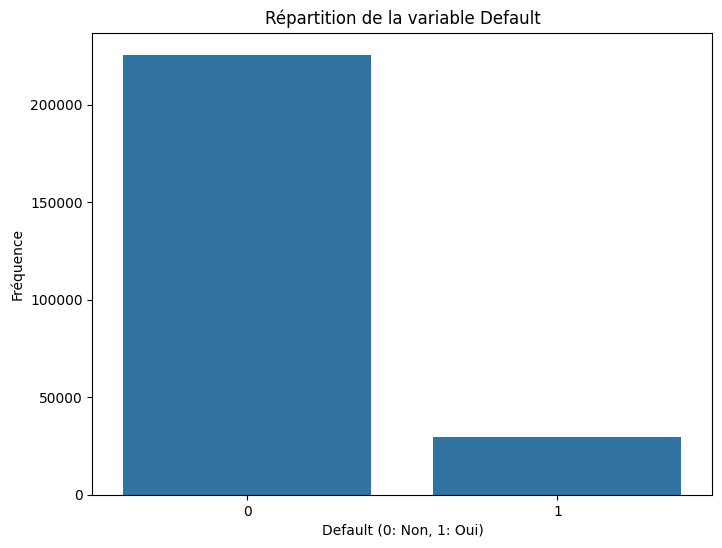

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compter le nombre d'observations pour chaque classe
default_counts = Data['Default'].value_counts()

# Afficher les résultats
print(default_counts)

# Visualiser la répartition
plt.figure(figsize=(8, 6))
sns.countplot(x='Default', data=Data)
plt.title('Répartition de la variable Default')
plt.xlabel('Default (0: Non, 1: Oui)')
plt.ylabel('Fréquence')
plt.show()

notre graphique déséquilibré montre un déséquilibre de notre dataset.
 La classe "Default = 0" (absence de défaut) est largement majoritaire par rapport à la classe "Default = 1" (défaut de paiement).

 pour le réquilibrage , nous allons utiliser la méthode SMOTE

# methode SMOTE 
- elle consiste à créer de nouvelles observations synthétiques pour la classe minoritaire (Default = 1) afin d'équilibrer le nombre d'observations dans les deux classes, la méthode SMOTE se fait que sur les variables numerique, j'ai donc convertir mes variables categorielles en numerique

In [18]:
Data.drop('LoanID',axis = 1 , inplace=True)

Data.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype='object')

In [19]:
import pandas as pd
from imblearn.over_sampling import SMOTE


variables_categorielles = ['Education', 'EmploymentType', 'MaritalStatus', 
                           'HasMortgage', 'HasDependents', 'LoanPurpose', 
                           'HasCoSigner']
# encodage one-hot des variables catégorielles 
Data = pd.get_dummies(Data, columns=variables_categorielles, drop_first=True)

#Séparation des variables prédictives et de la variable cible

X = Data.drop('Default', axis=1)
y = Data['Default']
# application du smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

print(data_resampled['Default'].value_counts())

Default
0    225694
1    225694
Name: count, dtype: int64


- maitenant que nos données sont équilibre passons a la separation des données en train et en test

In [20]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#Séparer les données en features (X) et target (y)
X = data_resampled.drop('Default', axis=1)
y = data_resampled['Default']

#Diviser les données en train et test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 361110
Taille de l'ensemble de test : 90278


# maintenant que nous avons separer notre donnes , passons aux choix et entraînement du modèles en faisant differentes tests
Arbre de décision (DecisionTreeClassifier) pour l'interprétabilité.
Random Forest (RandomForestClassifier) pour la robustesse.
XGBoost (XGBClassifier) pour la performance.
Validation croisée (cross_val_score()) pour évaluer la stabilité du modèle

# avec Arbre de décision (DecisionTreeClassifier) pour l'interprétabilité

In [21]:
#Arbre de décision (DecisionTreeClassifier) 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialisation du modèle
tree = DecisionTreeClassifier(random_state=42)

# Validation croisée
scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
print("Arbre de décision :")
print(f"  Validation croisée : {scores}")
print(f"  Moyenne : {scores.mean()}")

# Entraînement du modèle
tree.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = tree.predict(X_test)

# Évaluation des performances
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy sur l'ensemble de test : {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("-" * 50)

Arbre de décision :
  Validation croisée : [0.84442414 0.84352413 0.84269336 0.8429149  0.84450721]
  Moyenne : 0.8436127495776911
  Accuracy sur l'ensemble de test : 0.8490329869957243
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     45127
           1       0.84      0.86      0.85     45151

    accuracy                           0.85     90278
   macro avg       0.85      0.85      0.85     90278
weighted avg       0.85      0.85      0.85     90278

[[37642  7485]
 [ 6144 39007]]
--------------------------------------------------


# interpretation du 

# avec  (RandomForestClassifier) pour la robustesse

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialisation du modèle
forest = RandomForestClassifier(random_state=42)

# Validation croisée
scores = cross_val_score(forest, X_train, y_train, cv=5, scoring='accuracy')
print("randon forest:")
print(f"  Validation croisée : {scores}")
print(f"  Moyenne : {scores.mean()}")

# Entraînement du modèle
forest.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = forest.predict(X_test)

# Évaluation des performances
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy sur l'ensemble de test : {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("-" * 50)

# avec XGBoost (XGBClassifier) pour la performance

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialisation du modèle
xgboost = XGBClassifier(random_state=42)

# Validation croisée
scores = cross_val_score(xgboost, X_train, y_train, cv=5, scoring='accuracy')
print("XGBoost :")
print(f"  Validation croisée : {scores}")
print(f"  Moyenne : {scores.mean()}")

# Entraînement du modèle
xgboost.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = xgboost.predict(X_test)

# Évaluation des performances
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy sur l'ensemble de test : {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("-" * 50)

# evaluation des performances de nos modèles
1- Calculer Accuracy(le pourcentage de predictions correctes ), Precision(Proportion de vrais positifs parmi les prédictions positives.), Recall(Proportion de vrais positifs parmi les observations réelles positives.), F1-score(Moyenne harmonique de la précision et du rappel).
2- Tracer une matrice de confusion (confusion_matrix + sns.heatmap) (Matrice de confusion : Tableau qui visualise le nombre de prédictions correctes et incorrectes pour chaque classe).
3-Tracer la courbe ROC-AUC (roc_curve, auc)(Courbe qui représente la performance d'un classificateur binaire à différents seuils de classification. L'AUC (Area Under the Curve) est une mesure de la capacité du classificateur à distinguer les classes.).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Prédictions sur l'ensemble de test
y_pred = tree.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Arbre de décision :")
print(f"  Accuracy : {accuracy}")
print(f"  Precision : {precision}")
print(f"  Recall : {recall}")
print(f"  F1-score : {f1}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.title('Matrice de confusion - Arbre de décision')
plt.xlabel('Prédictions')  
plt.ylabel('Réalité')    
plt.show()

# Courbe ROC-AUC
y_prob = tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Arbre de décision')
plt.legend(loc="lower right")
plt.show()

print("-" * 50)

# randon forest

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Prédictions sur l'ensemble de test
y_pred = forest.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Forêt aléatoire :")
print(f"  Accuracy : {accuracy}")
print(f"  Precision : {precision}")
print(f"  Recall : {recall}")
print(f"  F1-score : {f1}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.title('Matrice de confusion - Forêt aléatoire')
plt.xlabel('Prédictions')  
plt.ylabel('Réalité')    
plt.show()

# Courbe ROC-AUC
y_prob = forest.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Forêt aléatoire')
plt.legend(loc="lower right")
plt.show()

print("-" * 50)

pour XGBoost

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Prédictions sur l'ensemble de test
y_pred = xgboost.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("XGBoost :")
print(f"  Accuracy : {accuracy}")
print(f"  Precision : {precision}")
print(f"  Recall : {recall}")
print(f"  F1-score : {f1}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.title('Matrice de confusion - XGBoost')
plt.xlabel('Prédictions')  
plt.ylabel('Réalité')    
plt.show()

# Courbe ROC-AUC
y_prob = xgboost.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - XGBoost')
plt.legend(loc="lower right")
plt.show()

print("-" * 50)

# Interpretability & Explicability with SHAP 

## RandomForest model

In [ ]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_train)
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

In [ ]:
explainer = shap.Explainer(forest, X_train)
shap_values = explainer(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0].values,
                X_test.iloc[0])

## DecisionTree model

In [ ]:
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_train)
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

In [ ]:
explainer = shap.Explainer(tree, X_train)
shap_values = explainer(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0].values,
                X_test.iloc[0])

## XGBoost model

In [ ]:
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(X_train)
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

In [ ]:
explainer = shap.Explainer(xgboost, X_train)
shap_values = explainer(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0].values,
                X_test.iloc[0])